In [25]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import collections
import os

colors = sns.color_palette('Set2', 20)

alphas=[0.001, 0.0001, 0.00001]
sns.set_context('poster')
sns.set_style('white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
sns.set_palette('Paired', 20)

import numpy

lgn_fontsize = plt.rcParams['legend.fontsize']
%matplotlib inline

In [2]:
backmapping_energies = collections.defaultdict(list)
fields = None
for f in sorted(filter(lambda x: x.endswith('xvg'), os.listdir('backmapping_energy/')), key=lambda x: int(x.split('_')[2].replace('.xvg', ''))):
    if not f.endswith('xvg'):
        continue
    alp = float(f.split('_')[1])
    
    d = np.loadtxt(os.path.join('backmapping_energy/', f), skiprows=1)
    fields = {x: k for k, x in enumerate(open(os.path.join('backmapping_energy/', f), 'r').readline().split())}
    print(alp, d.shape)
    backmapping_energies[alp].append(d)

0.001 (27, 74)
0.0001 (45, 74)
1e-05 (224, 74)
0.0001 (45, 74)
1e-05 (224, 74)
0.001 (27, 74)
0.001 (27, 74)
0.0001 (45, 74)
1e-05 (224, 74)


# Potential energy

In [3]:
pot_fields = [v for k, v in fields.items() if ('angle' in k or 'bond' in k or 'dih' in k or 'lj' in k or 'tab' in k) and not 'angle_253' in k]
angle_fields = [v for k, v in fields.items() if 'angle' in k and not 'angle_253' in k]
bond_fields = [v for k, v in fields.items() if 'bond' in k]
dih_fields = [v for k, v in fields.items() if 'dih' in k]
nonbond_fields = [v for k, v in fields.items() if 'lj' in k or 'tab' in k]
tot_pot_fields = angle_fields + bond_fields + dih_fields + nonbond_fields

In [4]:
total_bond_energy7 = {}
total_angle_energy7 = {}
total_dih_energy7 = {}
total_nonbond_energy7 = {}
total_pot_energy7 = {}
for alp in backmapping_energies.keys():
    ss = []
    s = backmapping_energies[alp]
    for s1 in s:
        sum_f = np.sum(s1[:, bond_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_bond_energy7[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, angle_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_angle_energy7[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, dih_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_dih_energy7[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, nonbond_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_nonbond_energy7[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, tot_pot_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_pot_energy7[alp] = np.array(ss)

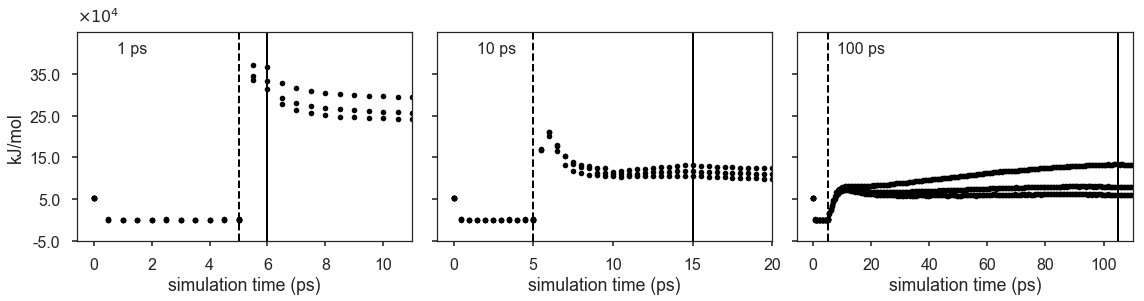

In [5]:
plt.rcParams['figure.figsize'] = (16, 4)
ymin, ymax, ystep = -50000, 450000, 100000
mm = 10**4
for i, alp in enumerate(sorted(backmapping_energies.keys(), reverse=True), 1):
    plt.subplot(1,3,i)
    for j, s in enumerate(total_pot_energy7[alp]):
        l, = plt.plot(s[:, 0], s[:, 1]/mm, 'k.')
    plt.legend(loc=1)
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.12, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    plt.axvline(x=5, linewidth=2.0, linestyle='--', color='k')
    plt.axvline(x=5+(1.0/alp/1000), linewidth=2.0, linestyle='-', color='k')
    plt.ylim([ymin/mm, ymax/mm])
    yticks = np.arange(ymin, ymax, ystep)/mm
    if i == 1:
        plt.yticks(yticks, yticks)
        plt.ylabel(r'kJ/mol')
        plt.annotate(r'$\times 10^4$', xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
    else:
        plt.yticks(yticks, [])
    plt.xlim(xmax=5+(1.0/alp/1000)+5)
    plt.xlabel('simulation time (ps)')
#plt.xlim([0, 1200])
plt.tight_layout()
plt.savefig('mf3_aa_potential_bck.pdf', dpi=200, bbox_inches='tight')

In [6]:
gmx_pot_energy = collections.defaultdict(list)
for f in os.listdir('eq_energy/'):
    if f.endswith('xvg'):
        alpha = float(f.split('_')[1])
        d = np.loadtxt(os.path.join('eq_energy', f), comments=('@', '#'))
        gmx_pot_energy[alpha].append(d)

In [7]:
eq_header = {
    'time': 0,
    "bond": 1,
    "angle": 2,
    "rb_dih": 3,
    "lj-14": 4,
    "coulomb-14": 5,
    "lj": 6, 
    "coulomb": 7,
    "potential": 9
}

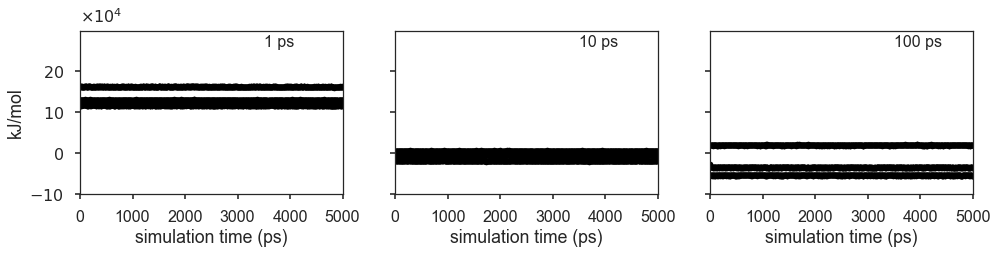

In [8]:
plt.rcParams['figure.figsize'] = (16, 3)
pot = 'potential'
ymin, ymax, ystep = -100000, 300000, 100000
mm = 10**4
for i, (alp, l) in enumerate(sorted(gmx_pot_energy.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    for s in l:
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/mm, 'k.')
    l = np.array(l)
    avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    std_pot = np.var(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    plt.ylim([ymin/mm, ymax/mm])
    yticks = np.arange(ymin, ymax, ystep)/mm
    plt.xlim([0, 5000])
    if i == 1:
        plt.yticks(yticks, [r'${:.0f}$'.format(x) for x in yticks])
        plt.ylabel(r'kJ/mol')
        plt.annotate(r'$\times 10^4$', xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
    else:
        plt.yticks(yticks, [])
    plt.xlabel('simulation time (ps)')        
    
#plt.tight_layout()
plt.savefig('mf3_aa_eq_potential.pdf', dpi=200, bbox_inches='tight')

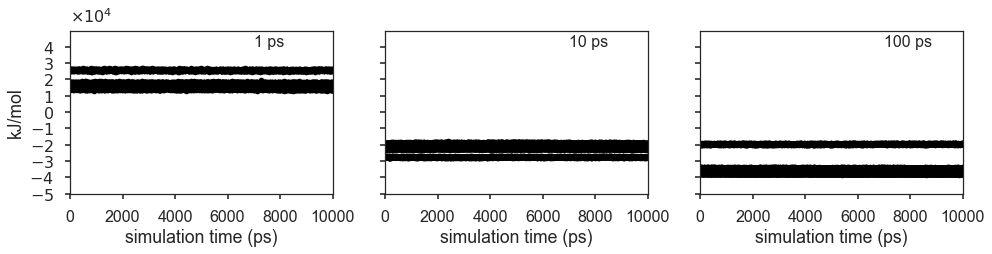

In [9]:
plt.rcParams['figure.figsize'] = (16, 3)
pot = 'lj'
ymin, ymax, ystep = -50000, 50000, 10000
mm = 10**4
for i, (alp, l) in enumerate(sorted(gmx_pot_energy.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    for s in l:
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/mm, 'k.')
    l = np.array(l)
    avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    std_pot = np.var(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    plt.ylim([ymin/mm, ymax/mm])
    yticks = np.arange(ymin, ymax, ystep)/mm
    plt.xlim([0, 10000])
    if i == 1:
        plt.yticks(yticks, [r'${:.0f}$'.format(x) for x in yticks])
        plt.ylabel(r'kJ/mol')
        plt.annotate(r'$\times 10^4$', xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
    else:
        plt.yticks(yticks, [])
    plt.xlabel('simulation time (ps)')        
    
plt.savefig('mf3_aa_eq_lj.pdf', dpi=200, bbox_inches='tight')

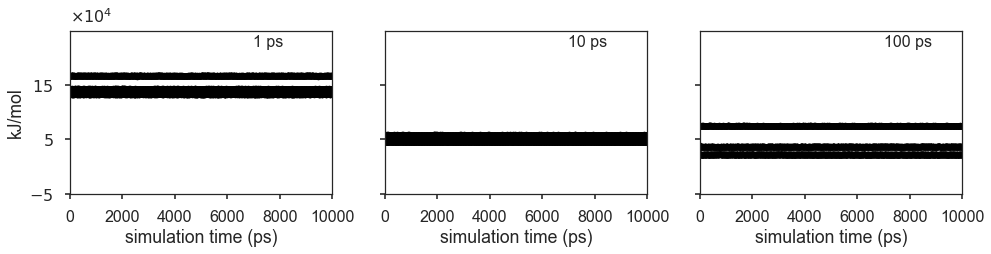

In [10]:
plt.rcParams['figure.figsize'] = (16, 3)
pot = 'bond'
ymin, ymax, ystep = -50000, 250000, 100000
mm = 10**4
for i, (alp, l) in enumerate(sorted(gmx_pot_energy.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    for s in l:
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/mm, 'k.')
    l = np.array(l)
    avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    std_pot = np.var(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    plt.ylim([ymin/mm, ymax/mm])
    yticks = np.arange(ymin, ymax, ystep)/mm
    plt.xlim([0, 10000])
    if i == 1:
        plt.yticks(yticks, [r'${:.0f}$'.format(x) for x in yticks])
        plt.ylabel(r'kJ/mol')
        plt.annotate(r'$\times 10^4$', xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
    else:
        plt.yticks(yticks, [])
    plt.xlabel('simulation time (ps)')        
    
plt.savefig('mf3_aa_eq_bond.pdf', dpi=200, bbox_inches='tight')

# RDF

In [4]:
rdfs = collections.defaultdict(dict) # at_name: alpha: rdfs
for f in sorted(os.listdir('rdf')):
    if f.endswith('xvg') and f.startswith('rdf'):
        print(f)
        t = f.split('_')
        at_name = '_'.join(t[3:]).replace('.xvg', '')
        d = np.loadtxt(os.path.join('rdf', f), comments=('@', '#'))
        alpha = float(t[2])
        if alpha not in rdfs[at_name]:
            rdfs[at_name][alpha] = []
        rdfs[at_name][alpha].append(d)
print(rdfs.keys())

rdf_s1_0.00001_C_H.xvg
rdf_s1_0.00001_C_N.xvg
rdf_s1_0.00001_C_O.xvg
rdf_s1_0.00001_N1_O.xvg
rdf_s1_0.00001_N2_O.xvg
rdf_s1_0.00001_N_H.xvg
rdf_s1_0.00001_O_H.xvg
rdf_s1_0.00001_O_N.xvg
rdf_s1_0.00001_ring_ring.xvg
rdf_s1_0.0001_C_H.xvg
rdf_s1_0.0001_C_N.xvg
rdf_s1_0.0001_C_O.xvg
rdf_s1_0.0001_N1_O.xvg
rdf_s1_0.0001_N2_O.xvg
rdf_s1_0.0001_N_H.xvg
rdf_s1_0.0001_O_H.xvg
rdf_s1_0.0001_O_N.xvg
rdf_s1_0.0001_rdf.xvg
rdf_s1_0.0001_ring_ring.xvg
rdf_s1_0.001_C123_O.xvg
rdf_s1_0.001_C_H.xvg
rdf_s1_0.001_C_N.xvg
rdf_s1_0.001_C_O.xvg
rdf_s1_0.001_N1_O.xvg
rdf_s1_0.001_N2_O.xvg
rdf_s1_0.001_N_H.xvg
rdf_s1_0.001_O_H.xvg
rdf_s1_0.001_O_N.xvg
rdf_s1_0.001_rdf.xvg
rdf_s1_0.001_ring_ring.xvg
rdf_s2_0.00001_C_H.xvg
rdf_s2_0.00001_C_N.xvg
rdf_s2_0.00001_C_O.xvg
rdf_s2_0.00001_N1_O.xvg
rdf_s2_0.00001_N_H.xvg
rdf_s2_0.00001_O_H.xvg
rdf_s2_0.00001_O_N.xvg
rdf_s2_0.00001_ring_ring.xvg
rdf_s2_0.0001_C_H.xvg
rdf_s2_0.0001_C_N.xvg
rdf_s2_0.0001_C_O.xvg
rdf_s2_0.0001_N_H.xvg
rdf_s2_0.0001_O_H.xvg
rdf_s2_0.0001_

In [5]:
avg_rdfs = collections.defaultdict(dict)
for at_name in rdfs:
    for i, (alpha, l) in enumerate(sorted(rdfs[at_name].items(), reverse=True), 1):
        avg_l = np.average(l, axis=0)
        std_l = np.std(l, axis=0)
        s = np.zeros((avg_l.shape[0], avg_l.shape[1]+1))
        s[:, (0, 1)] = avg_l
        s[:, 2] = std_l[:, 1]
        avg_rdfs[at_name][alpha] = s

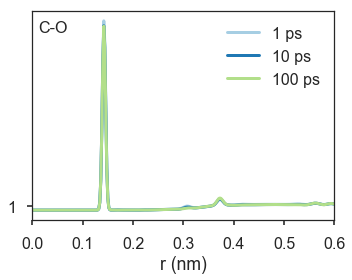

In [6]:
plt.rcParams['figure.figsize'] = (5, 4)
at_name = 'C_O'
for alp, d in sorted(avg_rdfs[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=0)
#plt.xlim([0, 0.2])
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_c_o.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

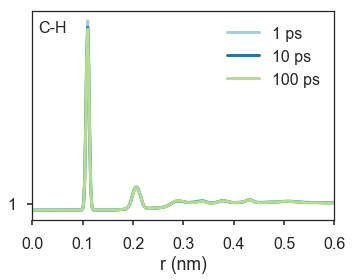

In [7]:
plt.rcParams['figure.figsize'] = (5, 4)
at_name = 'C_H'
for alp, d in sorted(avg_rdfs[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=0)
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_c_h.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

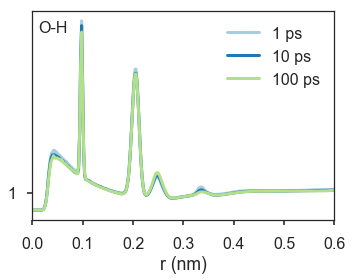

In [8]:
plt.rcParams['figure.figsize'] = (5, 4)
at_name = 'O_H'
for alp, d in sorted(avg_rdfs[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=0)
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_o_h.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

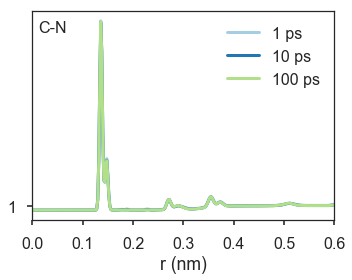

In [9]:
plt.rcParams['figure.figsize'] = (5, 4)
at_name = 'C_N'
for alp, d in sorted(avg_rdfs[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=0)
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_c_n.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

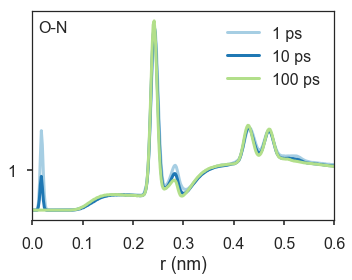

In [10]:
plt.rcParams['figure.figsize'] = (5, 4)
at_name = 'O_N'
for alp, d in sorted(avg_rdfs[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=0)
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_o_n.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

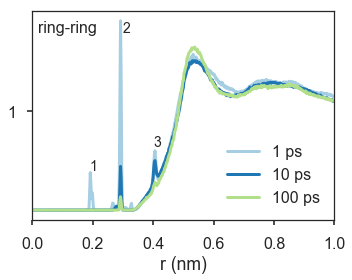

In [11]:
plt.rcParams['figure.figsize'] = (5, 4)
at_name = 'ring_ring'
for alp, d in sorted(avg_rdfs[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 1.0])
plt.legend(loc=0)
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.annotate('1', xy=(0.19, 0.4), xycoords='data', fontsize=14)
plt.annotate('2', xy=(0.3, 1.8), xycoords='data', fontsize=14)
plt.annotate('3', xy=(0.4, 0.65), xycoords='data', fontsize=14)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_ring_ring.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

In [12]:
# CG ring-ring
d = np.loadtxt('other_data/cg-ring-ring.xvg', usecols=(0,1))

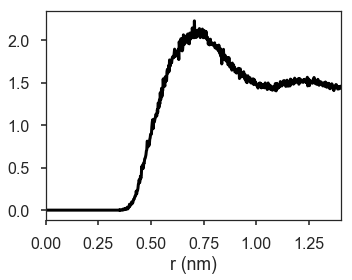

In [15]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.plot(d[:, 0], d[:, 1], color='k', linewidth=3)
plt.xlim([0, 1.4])
plt.xlabel('r (nm)')
plt.tight_layout()
plt.savefig('mf3_cg_ring_ring.pdf', dpi=200, bbox_inches = 'tight',
    pad_inches = 0)

# Fixed issue

## Backmapping energy

In [111]:
backmapping_energies2 = collections.defaultdict(list)
fields = None
for f in sorted(filter(lambda x: x.endswith('xvg'), os.listdir('backmapping_energy2/')), key=lambda x: int(x.split('_')[2].replace('.xvg', ''))):
    if not f.endswith('xvg'):
        continue
    alp = float(f.split('_')[1])
    
    d = np.loadtxt(os.path.join('backmapping_energy2/', f), skiprows=1)
    fields = {x: k for k, x in enumerate(open(os.path.join('backmapping_energy2/', f), 'r').readline().split())}
    print(alp, d.shape)
    backmapping_energies2[alp].append(d)

0.001 (37, 75)
0.0001 (55, 75)
1e-05 (234, 75)
0.0001 (55, 75)
1e-05 (234, 75)
0.001 (37, 75)
0.0001 (55, 75)
0.001 (37, 75)
1e-05 (234, 75)
0.0001 (55, 75)
0.001 (37, 75)
1e-05 (234, 75)
0.0001 (55, 75)
1e-05 (234, 75)
0.001 (37, 75)
0.0001 (55, 75)
1e-05 (234, 75)
0.001 (37, 75)


In [112]:
pot_fields = [v for k, v in fields.items() if ('angle' in k or 'bond' in k or 'dih' in k or 'lj' in k or 'tab' in k) and not 'angle_253' in k]
angle_fields = [v for k, v in fields.items() if 'angle' in k and not 'angle_253' in k]
bond_fields = [v for k, v in fields.items() if 'bond' in k]
dih_fields = [v for k, v in fields.items() if 'dih' in k]
nonbond_fields = [v for k, v in fields.items() if 'lj' in k or 'tab' in k]
tot_pot_fields = angle_fields + bond_fields + dih_fields + nonbond_fields

In [113]:
total_bond_energy2 = {}
total_angle_energy2 = {}
total_dih_energy2 = {}
total_nonbond_energy2 = {}
total_pot_energy2 = {}
for alp in backmapping_energies2.keys():
    ss = []
    s = backmapping_energies2[alp]
    for s1 in s:
        sum_f = np.sum(s1[:, bond_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_bond_energy2[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, angle_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_angle_energy2[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, dih_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_dih_energy2[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, nonbond_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_nonbond_energy2[alp] = np.array(ss)
    
    ss = []
    for s1 in s:
        sum_f = np.sum(s1[:, tot_pot_fields], axis=1)
        ss.append(np.column_stack((s1[:, fields['time']], sum_f)))
    total_pot_energy2[alp] = np.array(ss)

/home/teodor/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


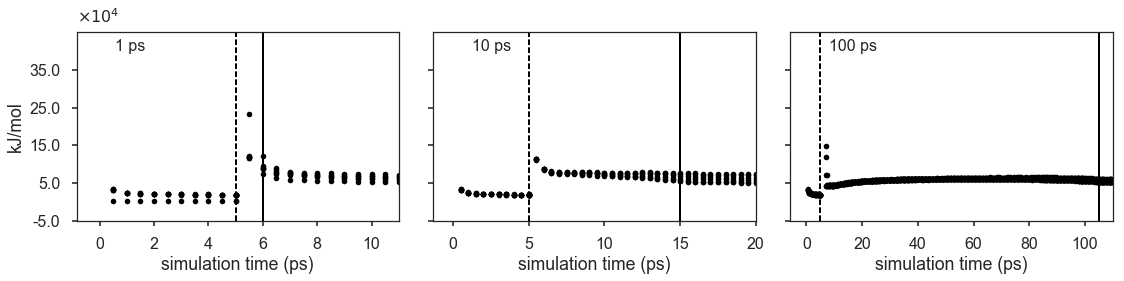

In [114]:
plt.rcParams['figure.figsize'] = (16, 4)
ymin, ymax, ystep = -50000, 450000, 100000
mm = 10**4
for i, alp in enumerate(sorted(backmapping_energies2.keys(), reverse=True), 1):
    plt.subplot(1,3,i)
    for j, s in enumerate(total_pot_energy2[alp]):
        l, = plt.plot(s[:, 0], s[:, 1]/mm, 'k.')
    plt.legend(loc=1)
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.12, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    plt.axvline(x=5, linewidth=2.0, linestyle='--', color='k')
    plt.axvline(x=5+(1.0/alp/1000), linewidth=2.0, linestyle='-', color='k')
    plt.ylim([ymin/mm, ymax/mm])
    yticks = np.arange(ymin, ymax, ystep)/mm
    if i == 1:
        plt.yticks(yticks, yticks)
        plt.ylabel(r'kJ/mol')
        plt.annotate(r'$\times 10^4$', xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
    else:
        plt.yticks(yticks, [])
    plt.xlim(xmax=5+(1.0/alp/1000)+5)
    plt.xlabel('simulation time (ps)')
#plt.xlim([0, 1200])
plt.tight_layout()
plt.savefig('mf3_aa_potential_bck_fix.pdf', dpi=200, bbox_inches='tight')

## Eq energy

In [139]:
gmx_pot_energy2 = collections.defaultdict(list)
for f in os.listdir('eq_energy2/'):
    if f.endswith('xvg'):
        alpha = float(f.split('_')[1])
        d = np.loadtxt(os.path.join('eq_energy2', f), comments=('@', '#'))
        gmx_pot_energy2[alpha].append(d)

In [140]:
eq_header = {
    'time': 0,
    "bond": 1,
    "angle": 2,
    "rb_dih": 3,
    "lj-14": 4,
    "coulomb-14": 5,
    "lj": 6, 
    "coulomb": 7,
    "potential": 9
}

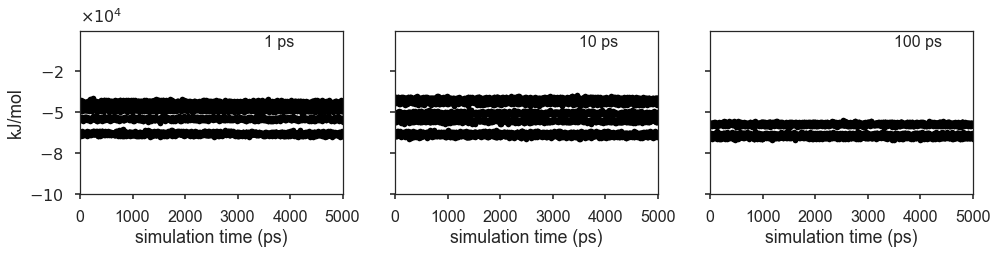

In [141]:
plt.rcParams['figure.figsize'] = (16, 3)
pot = 'potential'
ymin, ymax, ystep = -100000, 0, 25000
mm = 10**4
for i, (alp, l) in enumerate(sorted(gmx_pot_energy2.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    for s in l:
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/mm, 'k.')
    l = np.array(l)
    #avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    #std_pot = np.var(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    plt.ylim([ymin/mm, ymax/mm])
    yticks = np.arange(ymin, ymax, ystep)/mm
    plt.xlim([0, 5000])
    if i == 1:
        plt.yticks(yticks, [r'${:.0f}$'.format(x) for x in yticks])
        plt.ylabel(r'kJ/mol')
        plt.annotate(r'$\times 10^4$', xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
    else:
        plt.yticks(yticks, [])
    plt.xlabel('simulation time (ps)')        
    
#plt.tight_layout()
plt.savefig('mf3_aa_eq_potential_fix.pdf', dpi=200, bbox_inches='tight')

In [142]:
RT = 0.0083144621 * 298.0

0.001 0.722568167932 0.158110153247 0.382994535556
0.0001 0.722400677002 0.180281315308 0.489901975925
1e-05 0.5706132079 0.0770600195042 0.16404223237


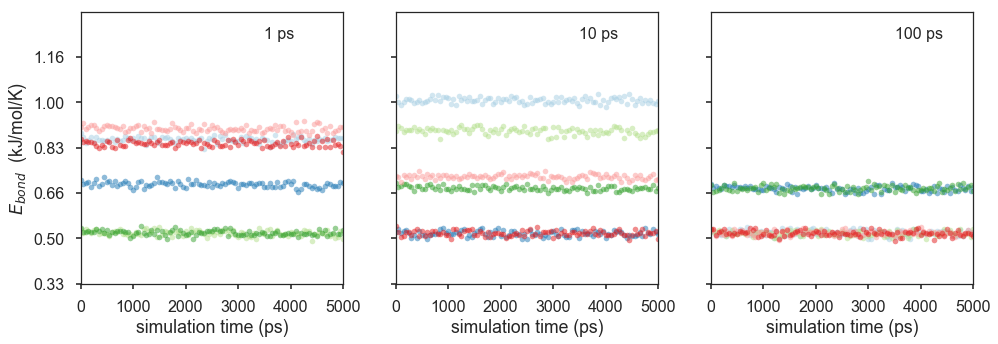

In [143]:
plt.rcParams['figure.figsize'] = (16, 5)
pot = 'bond'
ymin, ymax, ystep = 10000, 40000, 5000
m = 12150*RT
for i, (alp, l) in enumerate(sorted(gmx_pot_energy2.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    e_vals = []
    for s in l:
        e_vals.append(np.average(s[:, eq_header[pot]]))
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/m, '.', markevery=10, alpha=0.5, label='k')
    print(alp, np.average(e_vals)/m, np.std(e_vals)/m, (np.max(e_vals)-np.min(e_vals))/m)
    l = np.array(l)
    avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    #plt.annotate(r'$\langle E_{{{}}} \rangle = {:.2f} \; kJ/mol$'.format(pot, np.average(avg_pot)), 
    #             fontsize=lgn_fontsize,  xy=(0.05, 0.02), xycoords='axes fraction')
    plt.ylim([ymin/m, ymax/m])
    yticks = np.arange(ymin/m, ymax/m, ystep/m)
    if i == 1:
        plt.ylabel(r'$E_{{{}}}$  (kJ/mol/K)'.format(pot))
        #plt.annotate(r'$\times 10^4$'.format(m), xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
        plt.yticks(yticks, map('{:.2f}'.format, yticks))
    else:        
        plt.yticks(yticks, [])
    plt.xlim([0, 5000])
    plt.xlabel('simulation time (ps)')        
    
#plt.tight_layout()
plt.savefig('mf3_aa_eq_{}_fix.pdf'.format(pot), dpi=200, bbox_inches='tight')

0.001 0.61852102192 0.0163342638845 0.0492277121823
0.0001 0.61202425483 0.0156231393165 0.0408450916438
1e-05 0.598156481955 0.00316962938024 0.00953257111258


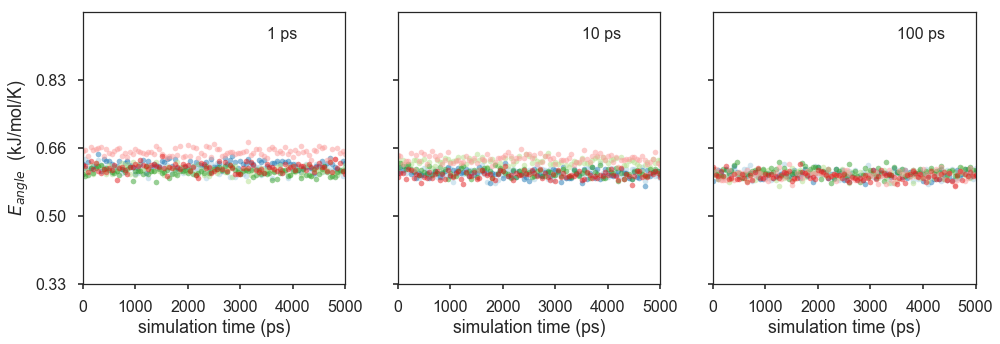

In [144]:
plt.rcParams['figure.figsize'] = (16, 5)
pot = 'angle'
ymin, ymax, ystep = 10000, 30000, 5000
mm = RT*17625
for i, (alp, l) in enumerate(sorted(gmx_pot_energy2.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    e_vals = []
    for s in l:
        e_vals.append(np.average(s[:, eq_header[pot]]))
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/m, '.', markevery=10, alpha=0.5)
    print(alp, np.average(e_vals)/m, np.std(e_vals)/m, (np.max(e_vals)-np.min(e_vals))/m)
    l = np.array(l)
    avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    #plt.annotate(r'$\langle E_{{{}}} \rangle = {:.2f} \; kJ/mol$'.format(pot, np.average(avg_pot)), 
    #             fontsize=lgn_fontsize,  xy=(0.05, 0.02), xycoords='axes fraction')
    plt.ylim([ymin/m, ymax/m])
    yticks = np.arange(ymin/m, ymax/m, ystep/m)
    if i == 1:
        plt.ylabel(r'$E_{{{}}}$  (kJ/mol/K)'.format(pot))
        #plt.annotate(r'$\times 10^4$'.format(m), xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
        plt.yticks(yticks, map('{:.2f}'.format, yticks))
    else:        
        plt.yticks(yticks, [])
    plt.xlim([0, 5000])
    plt.xlabel('simulation time (ps)')
    
#plt.tight_layout()
plt.savefig('mf3_aa_eq_{}_fix.pdf'.format(pot), dpi=200, bbox_inches='tight')

0.001 1.46907676491 0.0120802505421 0.0369219905153
0.0001 1.46945195674 0.0130855785339 0.0356409972169
1e-05 1.4559357774 0.00244366090638 0.00748788927234


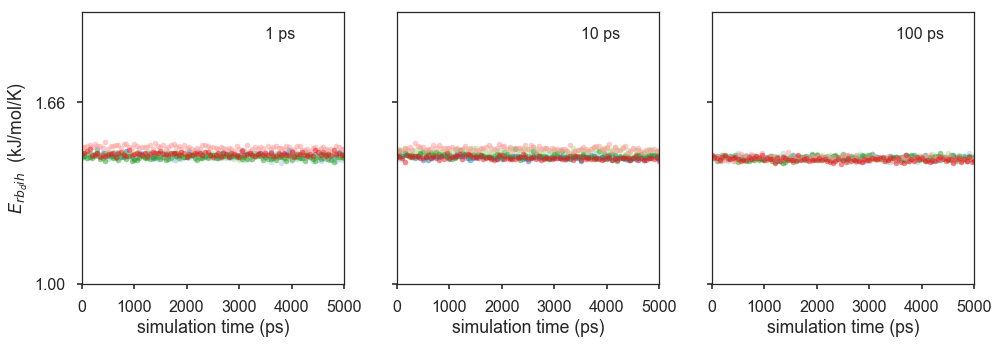

In [145]:
plt.rcParams['figure.figsize'] = (16, 5)
pot = 'rb_dih'
ymin, ymax, ystep = 30000, 60000, 20000
mm = RT*20100
for i, (alp, l) in enumerate(sorted(gmx_pot_energy2.items(), reverse=True), 1):
    plt.subplot(1,3,i)
    e_vals = []
    for s in l:
        e_vals.append(np.average(s[:, eq_header[pot]]))
        k, = plt.plot(s[:, 0], s[:, eq_header[pot]]/m, '.', markevery=10, alpha=0.5)
    print(alp, np.average(e_vals)/m, np.std(e_vals)/m, (np.max(e_vals)-np.min(e_vals))/m)
    l = np.array(l)
    avg_pot = np.average(l, axis=0)[:, eq_header[pot]]
    plt.annotate('{:.0f} ps'.format(1/alp/1000), xy=(0.7, 0.9), xycoords='axes fraction', fontsize=lgn_fontsize)
    #plt.annotate(r'$\langle E_{{{}}} \rangle = {:.2f} \; kJ/mol$'.format(pot, np.average(avg_pot)), 
    #             fontsize=lgn_fontsize,  xy=(0.05, 0.02), xycoords='axes fraction')
    plt.ylim([ymin/m, ymax/m])
    yticks = np.arange(ymin/m, ymax/m, ystep/m)
    if i == 1:
        plt.ylabel(r'$E_{{{}}}$  (kJ/mol/K)'.format(pot))
        #plt.annotate(r'$\times 10^4$'.format(m), xy=(0, 1.05), xycoords='axes fraction', fontsize=lgn_fontsize)
        plt.yticks(yticks, map('{:.2f}'.format, yticks))
    else:        
        plt.yticks(yticks, [])
    plt.xlim([0, 5000])
    plt.xlabel('simulation time (ps)')      
    
#plt.tight_layout()
plt.savefig('mf3_aa_eq_{}_fix.pdf'.format(pot), dpi=200, bbox_inches='tight')

## RDF2

In [16]:
rdfs2 = collections.defaultdict(dict) # at_name: alpha: rdfs
for f in sorted(os.listdir('rdf2')):
    if f.endswith('xvg') and f.startswith('rdf'):
        t = f.split('_')
        at_name = '_'.join(t[3:]).replace('.xvg', '')
        d = np.loadtxt(os.path.join('rdf2', f), comments=('@', '#'))
        alpha = float(t[2])
        if alpha not in rdfs2[at_name]:
            rdfs2[at_name][alpha] = []
        rdfs2[at_name][alpha].append(d)
print(rdfs2.keys())

dict_keys(['C_H', 'C_N', 'C_N_excl', 'C_O', 'N1_O', 'N2_O', 'N_H', 'O_H', 'O_N', 'O_N_excl', 'ring_ring'])


In [17]:
avg_rdfs2 = collections.defaultdict(dict)
for at_name in rdfs2:
    for i, (alpha, l) in enumerate(sorted(rdfs2[at_name].items(), reverse=True), 1):
        avg_l = np.average(l, axis=0)
        std_l = np.std(l, axis=0)
        s = np.zeros((avg_l.shape[0], avg_l.shape[1]+1))
        s[:, (0, 1)] = avg_l
        s[:, 2] = std_l[:, 1]
        if at_name == 'O_N_excl':
            r = 120
            ee = s[:r][:, 1]
            ee[ee > 0.02] = 0.0
            s[:r][:, 1] = ee
        if at_name == 'C_N_excl':
            r = 130
            ee = s[:r][:, 1]
            ee[ee > 0.001] = 0.0
            s[:r][:, 1] = ee
        avg_rdfs2[at_name][alpha] = s

1e-05 0.0001 0.101365647808
1e-05 0.001 0.0651810474329
0.0001 0.001 0.0471169543677
0.0712212165362


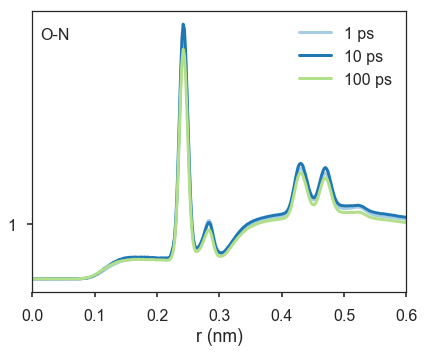

In [19]:
plt.rcParams['figure.figsize'] = (6, 5)
at_name = 'O_N'
for alp, d in sorted(avg_rdfs2[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=0)
# Calculate average RMSE between structures
alps = sorted(avg_rdfs2[at_name].keys())
rmses = []
for a1 in range(len(alps)):
    d1 = avg_rdfs2[at_name][alps[a1]]
    for a2 in range(a1+1, len(alps)):
        d2 = avg_rdfs2[at_name][alps[a2]]
        rmse = np.sqrt(np.average(pow(d2[:, 1]-d1[:, 1], 2)))
        rmses.append(rmse)
        print(alps[a1], alps[a2], rmse)
print(np.average(rmses))
#plt.xlim([0, 0.2])
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_{}_fix.pdf'.format(at_name), dpi=200, bbox_inches='tight', pad_inches=0)

1e-05 0.0001 0.0685192823631
1e-05 0.001 0.0429873456832
0.0001 0.001 0.0291164377018
0.0468743552494


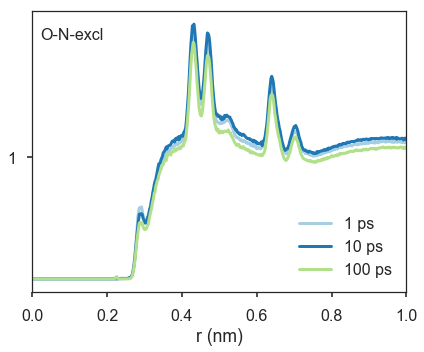

In [23]:
plt.rcParams['figure.figsize'] = (6, 5)
at_name = 'O_N_excl'
for alp, d in sorted(avg_rdfs2[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
plt.xlim([0, 1.0])
plt.legend(loc=4)
# Calculate average RMSE between structures
alps = sorted(avg_rdfs2[at_name].keys())
rmses = []
for a1 in range(len(alps)):
    d1 = avg_rdfs2[at_name][alps[a1]]
    for a2 in range(a1+1, len(alps)):
        d2 = avg_rdfs2[at_name][alps[a2]]
        rmse = np.sqrt(np.average(pow(d2[:, 1]-d1[:, 1], 2)))
        rmses.append(rmse)
        print(alps[a1], alps[a2], rmse)
print(np.average(rmses))
#plt.xlim([0, 0.2])
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_{}_fix.pdf'.format(at_name), dpi=200, bbox_inches='tight', pad_inches=0)

1e-05 0.0001 0.30926826471
1e-05 0.001 0.176449669746
0.0001 0.001 0.13311029809
0.206276077515


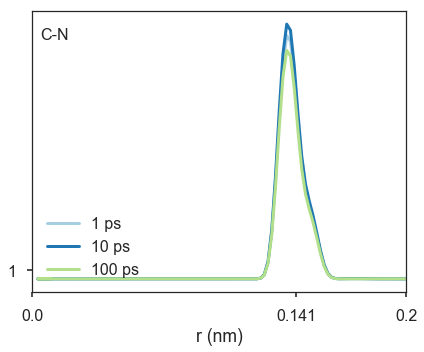

In [26]:
plt.rcParams['figure.figsize'] = (6, 5)
at_name = 'C_N'
for alp, d in sorted(avg_rdfs2[at_name].items(), reverse=True):
    plt.plot(smooth(d[:, 0]), smooth(d[:, 1]), label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 0.6])
plt.legend(loc=3)
# Calculate average RMSE between structures
alps = sorted(avg_rdfs2[at_name].keys())
rmses = []
for a1 in range(len(alps)):
    d1 = smooth(avg_rdfs2[at_name][alps[a1]][:, 1])
    for a2 in range(a1+1, len(alps)):
        d2 = smooth(avg_rdfs2[at_name][alps[a2]][:, 1])
        rmse = np.sqrt(np.average(pow(d2-d1, 2)))
        rmses.append(rmse)
        print(alps[a1], alps[a2], rmse)
print(np.average(rmses))
plt.xlim([0, 0.2])
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.xticks([0, 0.141, 0.2], [0.0, 0.141, 0.2])
plt.tight_layout()
plt.savefig('mf3_rdf_{}_fix.pdf'.format(at_name.lower()), dpi=200, bbox_inches='tight', pad_inches=0)

1e-05 0.0001 0.0654702128184
1e-05 0.001 0.0394876936569
0.0001 0.001 0.026183271862
0.0437137261124


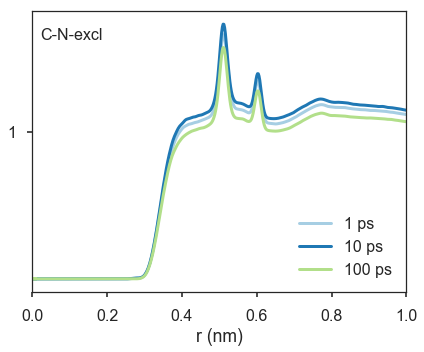

In [28]:
plt.rcParams['figure.figsize'] = (6, 5)
at_name = 'C_N_excl'
for alp, d in sorted(avg_rdfs2[at_name].items(), reverse=True):
    plt.plot(smooth(d[:, 0]), smooth(d[:, 1]), label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 1.0])
plt.legend(loc=4)
# Calculate average RMSE between structures
alps = sorted(avg_rdfs2[at_name].keys())
rmses = []
for a1 in range(len(alps)):
    d1 = smooth(avg_rdfs2[at_name][alps[a1]][:, 1])
    for a2 in range(a1+1, len(alps)):
        d2 = smooth(avg_rdfs2[at_name][alps[a2]][:, 1])
        rmse = np.sqrt(np.average(pow(d2-d1, 2)))
        rmses.append(rmse)
        print(alps[a1], alps[a2], rmse)
print(np.average(rmses))
#plt.xlim([0, 0.2])
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
plt.xlabel('r (nm)')
plt.yticks([1])
#plt.xticks([0, 0.141, 0.2], [0.0, 0.141, 0.2])
plt.tight_layout()
plt.savefig('mf3_rdf_{}_fix.pdf'.format(at_name.lower()), dpi=200, bbox_inches='tight', pad_inches=0)

1e-05 0.0001 0.0685363753658
1e-05 0.001 0.042216893856
0.0001 0.001 0.0303771475469
0.0470434722562


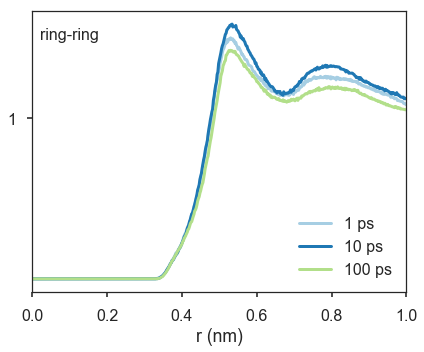

In [29]:
plt.rcParams['figure.figsize'] = (6, 5)
at_name = 'ring_ring'
for alp, d in sorted(avg_rdfs2[at_name].items(), reverse=True):
    plt.plot(d[:, 0], d[:, 1], label='{:.0f} ps'.format(1.0/alp/1000), linewidth=3)
    plt.xlim([0, 1.0])
plt.legend(loc=4)
# Calculate average RMSE between structures
alps = sorted(avg_rdfs2[at_name].keys())
rmses = []
for a1 in range(len(alps)):
    d1 = smooth(avg_rdfs2[at_name][alps[a1]][:, 1])
    for a2 in range(a1+1, len(alps)):
        d2 = smooth(avg_rdfs2[at_name][alps[a2]][:, 1])
        rmse = np.sqrt(np.average(pow(d2-d1, 2)))
        rmses.append(rmse)
        print(alps[a1], alps[a2], rmse)
print(np.average(rmses))
plt.annotate(at_name.replace('_', '-'), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=16)
# plt.annotate('1', xy=(0.19, 0.4), xycoords='data', fontsize=14)
# plt.annotate('2', xy=(0.3, 1.8), xycoords='data', fontsize=14)
# plt.annotate('3', xy=(0.4, 0.65), xycoords='data', fontsize=14)
plt.xlabel('r (nm)')
plt.yticks([1])
plt.tight_layout()
plt.savefig('mf3_rdf_ring_ring_fix.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

## Pull mechanism

In [4]:
pull_data = collections.defaultdict(dict)
for f in os.listdir('pull/'):
    if f.endswith('xvg'):
        direction = f.split('_')[1]
        alpha = float(f.split('_')[2])
        d = np.loadtxt(os.path.join('pull', f), comments=('@', '#'))
        if direction not in pull_data[alpha]:
            pull_data[alpha][direction] = []
        pull_data[alpha][direction].append(d)

In [5]:
import statsmodels.api as sm

def linregress(x, y, w=None):
    ret_tuple = collections.namedtuple('ret', ['slope', 'intercept', 'rvalue', 'std_intercept', 'std_slope'])
    X = sm.add_constant(x)
    if w is None:
        model = sm.OLS(y, X)
    else:
        model = sm.WLS(y, X, weights=1.0/w)
    result = model.fit()
    perr = np.sqrt(result.cov_params())
    out_vals = [result.params[1], result.params[0], np.sqrt(result.rsquared), perr[0][0], perr[1][1]]
    return ret_tuple(*out_vals)

/home/teodor/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


/home/teodor/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


0.001 3.22 3.01
0.0001 0.07 3.06
1e-05 -2.11 3.05


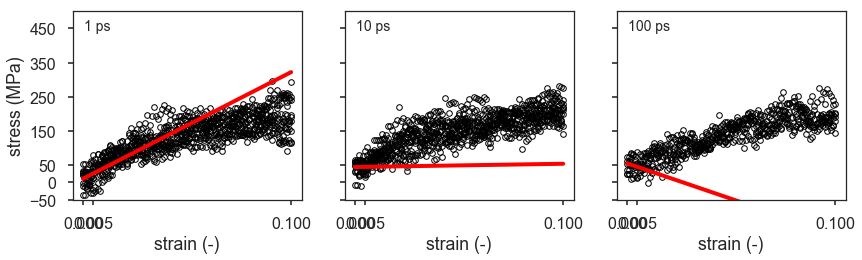

In [27]:
plt.rcParams['figure.figsize'] = (16, 4)
direction_index = {
    'x': (1, 4),
    'y': (2, 5),
    'z': (3, 6)
}
max_strain = 0.005
ymin, ymax = -50, 500
young_modulus = collections.defaultdict(dict)
for i, (alp, l) in enumerate(sorted(pull_data.items(), reverse=True), 1):
    plt.subplot(1,4,i)
    slopes, slopes_var, intercepts = [], [], []
    for direction, ll in l.items():
        ss, vv = [], []
        for s in ll:
            strain0 = s[:, direction_index[direction][0]][0]
            strain = (s[:, direction_index[direction][0]] - strain0)/strain0
            strain_limit = np.where(strain<=max_strain)[0][-1]
            stress = -1*s[:, direction_index[direction][1]]/10.0
            stress_s = smooth(stress, window_len=100)[:strain.shape[0]]
            r1 = linregress(strain[:strain_limit], stress[:strain_limit])
            slopes.append(r1.slope)
            slopes_var.append(r1.std_slope**2)
            intercepts.append(r1.intercept)
            plt.plot(
                strain, 
                stress_s, 
                label=direction, 
                marker='.', 
                linestyle='None', 
                color='k', 
                markerfacecolor='None', 
                markeredgewidth=1.0, markevery=100)
            ss.append(r1.slope)
            vv.append(r1.std_slope**2)
        young_modulus[alp][direction] = (np.average(ss), np.average(vv))
    plt.plot(strain, np.average(slopes)*strain+np.average(intercepts), 'r-', linewidth=4.0)
    print(alp, '{:.2f} {:.2f}'.format(
        np.average(slopes, weights=1.0/np.array(slopes_var))/1000, np.sqrt(np.average(slopes_var))/1000))
    l = np.array(l)
    plt.annotate(
        '{:.0f} ps'.format(1/alp/1000), 
        xy=(0.05, 0.9), 
        xycoords='axes fraction', 
        fontsize=14,
        horizontalalignment='left')
    plt.xlabel('strain (-)')
    if i == 1:
        plt.ylabel('stress (MPa)')
        plt.yticks(list(range(ymin, ymax, 100))+[0])
    else:
        plt.yticks(list(range(ymin, ymax, 100))+[0], [])
    plt.xticks([0.0, max_strain, 0.1])
    #plt.xlim(xmin=0, xmax=0.1)
    plt.ylim([ymin, ymax])
    
plt.tight_layout()
#plt.savefig('aa_pull_test.pdf', dpi=200)

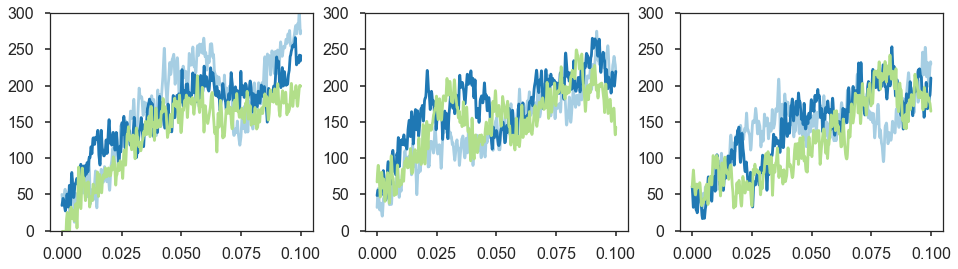

In [29]:
l = pull_data[0.0001]
for i, (direction, ll) in enumerate(l.items(), 1):
    plt.subplot(1,3,i)
    plt.ylim([0, 300])
    for s in ll:
        strain0 = s[:, direction_index[direction][0]][0]
        strain = (s[:, direction_index[direction][0]] - strain0)/strain0
        stress = -1*s[:, direction_index[direction][1]]/10.0
        stress_s = smooth(stress, window_len=100)[:strain.shape[0]]
        plt.plot(strain, stress_s)